# Project 1: Write a Data Science Blog Post
**Udacity Data Science Nanodegree Program**

**Author:** Jasmine David

**Date:** 12/22/20

## Data and Business Understanding 
Let's first look at our dataset to see what questions we can answer.
This dataset was sourced from the Organisation for Economic Co-operation and Development: 
https://data.oecd.org/agroutput/meat-consumption.htm
The dataset includes meat consumption data from 1990 to 2019 of the 27 countries (distinguished by country code) as well as the cumulative data of BRICS (the major emerging economies of Brazil, Russia, India, China and South Africa) and the cumulative data of the entire OECD(represented as WLD).

The dataset has 15 columns that include the following characteristics:
 - LOCATION: Country (Categorical)
 - INDICATOR: Shows that we are tracking meat consumption (Constant,Categorical)
 - Unnamed: 2: N/A (This column provides no useful information)
 - FREQUENCY: (Constant, Categorical, This column provides no useful information)
 - TIME: Year (Numerical)
 - Flag Codes: N/A (This column provides no useful information)
 - Tons of [Meat-type] - Tons of [Meat-type] consumed (Numerical) where <Meat-type> could be Beef, Pork, Poultry, or Sheep
 - <Meat-type> kg/cap  - [Meat-type] consumed in kg per capita (Numerical)
    where [Meat-type] could be Beef, Pork, Poultry, or Sheep

Now, imagine this data is being analyzed to answer questions for the OECD. They want to know what animal proteins people are eating around the world and how trends in meat consumption changed between 1990 and 2019. The might ask questions like which country has been consuming the most beef or which type of meat has seen the greatest increase in consumption since 1990. I will answer the questions below.

### Business Questions:
- Q1: Which country had the highest mean meat consumption in tons? Which country had the highest mean meat consumption per capita?
- Q2: In what year was the most beef per capita consumed worldwide? What is the median worldwide beef consumption per capita? In what year was beef consumption closest to the worldwide median?
- Q3: Based on our data, what is the average Brazilians preferred meat?
- Q4: What type of meat has seen the greatest rise in consumption? Which has seen the lowest?
- Q5: How well can we predict the Beef consumption per capita?

## Data Preparation

In [92]:
import pandas as pd
import numpy as np
import matplotlib as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline
# Read meat consumption data file in
meat_consump = pd.read_csv('./meat_consumption.csv')

In [93]:
meat_consump.head()

,LOCATION,INDICATOR,Unnamed: 2,FREQUENCY,TIME,Flag Codes,Tons of Beef,Beef kg/cap,Tons of Pork,Pork kg/cap,Tons of Poultry,Poultry kg/cap,Tons of Sheep,Sheep kg/cap
0,ARG,MEATCONSUMP,NaN,A,1990,NaN,2588.922,55.559,153.631,3.674,321.00,8.660,84.597,2.282
1,ARG,MEATCONSUMP,NaN,A,1991,NaN,2448.667,51.817,153.161,3.612,333.80,8.880,88.231,2.347
2,ARG,MEATCONSUMP,NaN,A,1992,NaN,2441.882,50.980,192.864,4.487,382.04,10.027,72.156,1.894
3,ARG,MEATCONSUMP,NaN,A,1993,NaN,2507.867,51.678,211.257,4.851,596.10,15.442,72.133,1.869
4,ARG,MEATCONSUMP,NaN,A,1994,NaN,2388.224,48.594,213.326,4.837,719.01,18.392,92.807,2.374


It is clear from the column variables that the data needs to be cleaned. First let's remove all of the constant and completely NaN columns as they don't add anything to the analysis.

In [94]:
# Shows that the whole Flag Codes col is NaN values
print("Flag codes is all null: " + str(meat_consump['Flag Codes'].isnull().sum()==meat_consump.shape[0]))
print("Unnamed: 2 is all null: " + str(meat_consump['Unnamed: 2'].isnull().sum()==meat_consump.shape[0]))

# Shows that the INDICATOR and FREQUENCY cols are both constant
print("All of INDICATOR's values: " + str(np.unique(meat_consump['INDICATOR'])))
print("All of FREQUENCY's values: " + str(np.unique(meat_consump['FREQUENCY'])))

Flag codes is all null: True
Unnamed: 2 is all null: True
All of INDICATOR's values: ['MEATCONSUMP']
All of FREQUENCY's values: ['A']


In [95]:
# Removes Flag Codes, Unnamed:2, INDICATOR, and FREQUENCY cols
meat_consump.pop('Flag Codes')
meat_consump.pop("Unnamed: 2")
meat_consump.pop('INDICATOR')
meat_consump.pop('FREQUENCY')
meat_consump.head()

,LOCATION,TIME,Tons of Beef,Beef kg/cap,Tons of Pork,Pork kg/cap,Tons of Poultry,Poultry kg/cap,Tons of Sheep,Sheep kg/cap
0,ARG,1990,2588.922,55.559,153.631,3.674,321.00,8.660,84.597,2.282
1,ARG,1991,2448.667,51.817,153.161,3.612,333.80,8.880,88.231,2.347
2,ARG,1992,2441.882,50.980,192.864,4.487,382.04,10.027,72.156,1.894
3,ARG,1993,2507.867,51.678,211.257,4.851,596.10,15.442,72.133,1.869
4,ARG,1994,2388.224,48.594,213.326,4.837,719.01,18.392,92.807,2.374


In [96]:
# Verify that missing data is handled
meat_consump.isnull().sum()

# Make heading style clear and consistent
meat_consump = meat_consump.rename(columns = {'LOCATION': 'Country'})
meat_consump = meat_consump.rename(columns = {'TIME': 'Year'})

Now that our data is clean and the labels are consistent, let's add some useful variables. What if we want to know something about a countries cumulative meat consumption in a given year? In this case, a column for the sum of all the _Tons of the [Meat-type]_ columns would be helpful. Let's do this for the _[Meat-type] kg/cap,_ columns as well. 

In [97]:
# Create variable for cumulative consumption in tons and cumulative meat consumption in kg/capita
meat_consump["Total meat in Tons"] = meat_consump["Tons of Beef"]+meat_consump["Tons of Pork"]+meat_consump["Tons of Poultry"]+meat_consump["Tons of Sheep"]
meat_consump["Total meat kg/cap"] = meat_consump["Beef kg/cap"]+meat_consump["Pork kg/cap"]+meat_consump["Poultry kg/cap"]+meat_consump["Sheep kg/cap"]

In [98]:
meat_consump.head()

,Country,Year,Tons of Beef,Beef kg/cap,Tons of Pork,Pork kg/cap,Tons of Poultry,Poultry kg/cap,Tons of Sheep,Sheep kg/cap,Total meat in Tons,Total meat kg/cap
0,ARG,1990,2588.922,55.559,153.631,3.674,321.00,8.660,84.597,2.282,3148.150,70.175
1,ARG,1991,2448.667,51.817,153.161,3.612,333.80,8.880,88.231,2.347,3023.859,66.656
2,ARG,1992,2441.882,50.980,192.864,4.487,382.04,10.027,72.156,1.894,3088.942,67.388
3,ARG,1993,2507.867,51.678,211.257,4.851,596.10,15.442,72.133,1.869,3387.357,73.840
4,ARG,1994,2388.224,48.594,213.326,4.837,719.01,18.392,92.807,2.374,3413.367,74.197


## Modelling & Results

### Q1a: Which country had the highest mean meat consumption in tons?

In [99]:
# Total amount of meat (ie. cattle, pork, poultry and sheep) in tons
# consumed by each country from 1990-2019.
a = meat_consump[meat_consump["Country"] != "WLD"]
b = a[meat_consump["Country"] != "OECD"]
c = b[meat_consump["Country"] != "BRICS"]
tot_consump_tons = c.groupby(["Country"])["Total meat in Tons"].mean()
# The output shows that China had the highest mean meat consumption between 1990 and 2019.
print(tot_consump_tons.head)



<bound method NDFrame.head of Country
ARG     3941.502333
AUS     2242.823933
BRA    15277.925567
CAN     2924.798400
CHE      537.629300
CHL     1157.534433
CHN    64264.869100
COL     1861.492100
EGY     1738.359367
ETH      453.060100
GBR     4414.721333
IDN     2312.453767
IND     4484.440133
IRN     2122.044200
ISR      618.403933
JPN     5631.790400
KAZ      933.494033
KOR     2429.474500
MEX     5685.377533
MYS     1470.186500
NGA     1037.097167
NOR      296.540200
NZL      399.036600
PAK     2271.650667
PER     1106.956700
PHL     2627.359600
PRY      330.676233
RUS     8146.655967
SAU     1234.957900
THA     1683.822733
TUR     1870.300467
UKR     2229.842500
USA    35389.436900
VNM     3456.014533
ZAF     2423.345833
Name: Total meat in Tons, dtype: float64>


<ipython-input-99-c8c4d8f667d8>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b = a[meat_consump["Country"] != "OECD"]
<ipython-input-99-c8c4d8f667d8>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c = b[meat_consump["Country"] != "BRICS"]


### Q1b: Which country had the highest mean meat consumption per capita?

In [100]:
# Total amount of meat (ie. cattle, pork, poultry and sheep) in kg/capita
# consumed by each country from 1990-2019.
tot_consump_cap = c.groupby(["Country"])["Total meat kg/cap"].mean()
print(tot_consump_cap)

# The result of the above shows that the USA had the highest mean meat consumption per capita between 1990 and 2019.

Country
ARG    76.878367
AUS    86.746567
BRA    64.298633
CAN    71.853267
CHE    55.825267
CHL    56.464733
CHN    38.352300
COL    33.991933
EGY    17.240267
ETH     4.013900
GBR    57.698833
IDN     8.306700
IND     3.178133
IRN    25.005133
ISR    75.217400
JPN    35.268167
KAZ    39.393867
KOR    39.322900
MEX    42.455700
MYS    47.698933
NGA     5.966767
NOR    48.921133
NZL    79.187633
PAK    11.338700
PER    32.692733
PHL    23.908533
PRY    45.062933
RUS    44.436367
SAU    42.665600
THA    21.339067
TUR    22.171600
UKR    32.833267
USA    96.032867
VNM    31.078400
ZAF    39.908967
Name: Total meat kg/cap, dtype: float64


### Q2: In what year was the most beef per capita consumed worldwide? What is the median worldwide beef consumption per capita? In what year was beef consumption closest to the worldwide median?

In [101]:
#
# WLD == world
print((meat_consump[meat_consump["Country"]=="WLD"])["Beef kg/cap"])
# Max beef consumption = entry 1097
meat_consump.loc[[1097]]
# The most meat per capita was consumed in 2007 at 6.941 kg per capita. The total beef consumed was 66169.507 TONS!

1080    6.564
1081    6.664
1082    6.936
1083    6.796
1084    6.853
1085    6.844
1086    6.793
1087    6.817
1088    6.734
1089    6.744
1090    6.731
1091    6.516
1092    6.677
1093    6.691
1094    6.687
1095    6.724
1096    6.861
1097    6.941
1098    6.770
1099    6.635
1100    6.574
1101    6.449
1102    6.433
1103    6.472
1104    6.362
1105    6.308
1106    6.357
1107    6.375
1108    6.401
1109    6.421
Name: Beef kg/cap, dtype: float64


,Country,Year,Tons of Beef,Beef kg/cap,Tons of Pork,Pork kg/cap,Tons of Poultry,Poultry kg/cap,Tons of Sheep,Sheep kg/cap,Total meat in Tons,Total meat kg/cap
1097,WLD,2007,66169.507,6.941,99470.602,11.627,88141.947,11.624,13172.86,1.737,266954.916,31.929


In [102]:
# Median beef consumption between 1990 and 2019:
(meat_consump[meat_consump["Country"]=="WLD"])["Beef kg/cap"].median()
# 6.682 kg/cap

6.682

In [103]:
print((meat_consump[meat_consump["Country"]=="WLD"])["Beef kg/cap"])
# entries 1092 and 1094
meat_consump.loc[[1092]]
# Worldwide beef consumption between 1990 and 2019 was closest to the median in 2002 and 2004.

1080    6.564
1081    6.664
1082    6.936
1083    6.796
1084    6.853
1085    6.844
1086    6.793
1087    6.817
1088    6.734
1089    6.744
1090    6.731
1091    6.516
1092    6.677
1093    6.691
1094    6.687
1095    6.724
1096    6.861
1097    6.941
1098    6.770
1099    6.635
1100    6.574
1101    6.449
1102    6.433
1103    6.472
1104    6.362
1105    6.308
1106    6.357
1107    6.375
1108    6.401
1109    6.421
Name: Beef kg/cap, dtype: float64


,Country,Year,Tons of Beef,Beef kg/cap,Tons of Pork,Pork kg/cap,Tons of Poultry,Poultry kg/cap,Tons of Sheep,Sheep kg/cap,Total meat in Tons,Total meat kg/cap
1092,WLD,2002,59808.478,6.677,93168.45,11.59,73680.104,10.341,11448.29,1.607,238105.322,30.215


**Answer**: The most meat per capita was consumed in 2007, the median meat consumption was 6.682 kg/cap and the median was approximated in 2002 and 2004

2002 and 2004 are relatively close to 2007. For median values to be so close to the maximum in time, there must have been a spike in beef consumption in the mid-2000s. Let's plot  

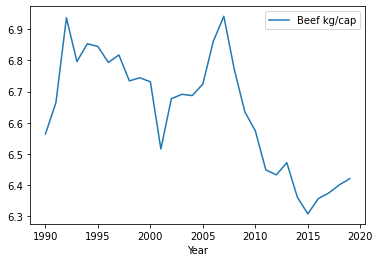

In [104]:
# create a dataset of just cumulative OECD (WLD) meat consumption and plot
world_consump = meat_consump[meat_consump["Country"]=="WLD"]
world_consump.plot(x="Year", y=["Beef kg/cap"])
# The plot shows world consumption beef consumption per capita over time.

As predicted, there was a huge spike in beef consumption between 2005 and 2007. It might be interesting to later examine why.

### Q3: Based on our data, what is the average Brazilians preferred meat?

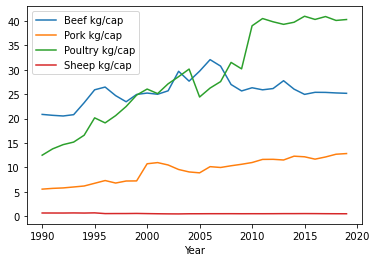

In [105]:
# create a dataset of just Brazil's meat consumption and plot
brazil_consump = meat_consump[meat_consump["Country"]=="BRA"]
brazil_consump.plot(x="Year", y=["Beef kg/cap","Pork kg/cap","Poultry kg/cap","Sheep kg/cap",])

In [107]:
# create a dataset of just Brazil's beef consumption in kg/cap and plot
bra_tot_beef = brazil_consump["Beef kg/cap"].sum()
# poultry
bra_tot_poultry = brazil_consump["Poultry kg/cap"].sum()

print("Brazil has consumed " + "%.3f" % round(bra_tot_beef, 2) + " of beef per capita.")

print("Brazil has also consumed " + "%.3f" % round(bra_tot_poultry, 2) + " of poultry per capita.")


Brazil has consumed 768.560 of beef per capita.
Brazil has also consumed 858.060 of poultry per capita.


**Answer:** We can conclude from the output that the average Brazilian's preferred type of meat is poultry.

 The plot above shows that Brazil consumed more beef than poultry per capita for most of the 90s but has since consumed more poultry. Which has the average Brazilian consumed more, cumulatively.

### Q4: What type of meat has seen the greatest rise in consumption? Which has seen the lowest? 

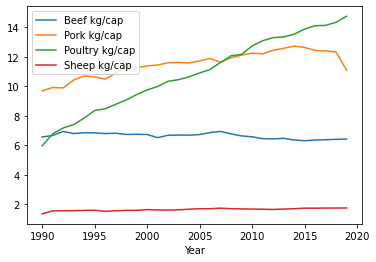

In [106]:
# create a dataset of just cumulative OECD (WLD) meat consumption and plot
world_consump.head()
world_consump.plot(x="Year", y=["Beef kg/cap","Pork kg/cap","Poultry kg/cap","Sheep kg/cap",])

The plot above shows that while the average person's beef and sheep consumption has remained constant, the consumption of poultry has more than doubled. Pork consumption was seeing a slow and steady increase, but dropped suddenly between 2017 and 2019.

**Answer**: Poultry has seen the greatest increase. Moreover since beef has seen a very slight decrease (negative increase) consumption, it has seen the smallest increase in consumption.

### Q5: How well can we predict the Beef consumption per capita?


Let's first use a heatmap to see which variables show a high correlation with _Beef kg/cap_. Lucky for us, all of our variables are numerical except for _Country_. Let's make boolean variables of the five largest beef consumers and see how they correlate with _Beef kg/cap_. These boolean variables will function binary numerical variables in the heatmap.

In [108]:
# total beef consumption of eat country in kg/capita from 1990 to 2019.
tot_beef_cap = c.groupby(["Country"])["Beef kg/cap"].sum()
tot_beef_cap

Country
ARG    1322.768
AUS     717.731
BRA     768.561
CAN     647.789
CHE     457.899
CHL     474.788
CHN      79.873
COL     363.857
EGY     228.462
ETH      80.484
GBR     341.906
IDN      45.548
IND      32.410
IRN     131.964
ISR     505.238
JPN     212.184
KAZ     522.620
KOR     228.322
MEX     294.548
MYS     128.859
NGA      46.803
NOR     413.075
NZL     586.484
PAK     158.006
PER     118.355
PHL      84.091
PRY     552.206
RUS     366.833
SAU     100.479
THA      67.903
TUR     161.591
UKR     248.418
USA     863.471
VNM     125.005
ZAF     334.386
Name: Beef kg/cap, dtype: float64

The five countries with the highest cumulative beef consumption per capita are Argentina(ARG), United States(USA), Brazil(BRA), Australia(AUS), and Canada(CAN). Let's create boolean variables for them to see the correlations with beef consumption per capita.

In [109]:
# create a new dataframe and add dummy variables
model_data = meat_consump
model_data["Country_USA"] = model_data["Country"]=="USA"
model_data["Country_CAN"] = model_data["Country"]=="CAN"
model_data["Country_ARG"] = model_data["Country"]=="ARG"
model_data["Country_AUS"] = model_data["Country"]=="AUS"
model_data["Country_BRA"] = model_data["Country"]=="BRA"

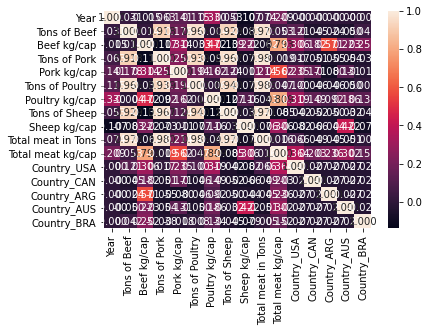

In [110]:
# heatmap
sns.heatmap(model_data.corr(),annot=True, fmt='.3f');

The heatmap indicates that the newly added boolean characteristics are all correlated with Beef kg/cap. Let's remove some variables and take a closer look.

In [111]:
# remove uncorrelated variables
model_data = model_data.drop(["Tons of Beef","Tons of Pork","Tons of Poultry","Tons of Sheep"],axis = 1)
model_data = model_data.drop(["Total meat in Tons","Total meat kg/cap"],axis = 1)

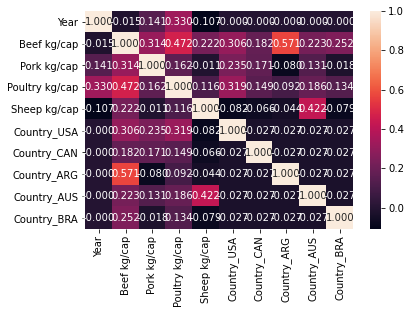

In [112]:
# new headmap
sns.heatmap(model_data.corr(),annot=True, fmt='.3f');

**Note:** Recall that the plots of meat consumption over time shows that world beef consumption per capita stayed relatively constant over time. This explains why Year and Beef kg/cap do not show much correlation.

To start, I will use all variables that show more than 25% correlation with _Beef kg/cap_ in my model.

In [113]:
# define variables to put into model
X = model_data[["Pork kg/cap","Poultry kg/cap","Country_USA","Country_ARG","Country_BRA"]]
y = model_data["Beef kg/cap"]


In [114]:
# split up training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size = .3, random_state = 42) 
# instantiate model
lm_model = LinearRegression(normalize = True)
# fit model
lm_model.fit(X_train,y_train)


LinearRegression(normalize=True)

In [115]:
# Make predictions
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

In [116]:
# Test predictions against test data using R2 metric 
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

In [117]:
print("The R2 value on the training data is: " + "%.5f" % round(train_score,5))
print("The R2 value on the test data is: " +  "%.5f" % round(test_score,5)) 

The R2 value on the training data is: 0.66728
The R2 value on the test data is: 0.65868


**Answer:** The model we used performed with an R2 of ~.66728 on the training data and an R2 of ~0.65868 on the test data. Not bad! Both R2s are close so there isn't overfitting and the model predicts accurately more than 50% of the time.

While this model is good, I suspect that it could be better if there were data predicting the health of the countries' respective economies or the average population in a given year.

## Deploy

Now that the business questions have been answered, the above model and analysis can be used. This analysis could be used by the WHO to observe correlations with the consumption of beef and the rates of  cardiovascular disease in growing economies. Alternatively, the OECS could have used analysis simiilar to that of _Q3_ or _Q5_ to start campaigning against the consumption of large livestock like beef and pork due to the effect on the environment. Conversely, beef suppliers could use the model from _Q5_ to predict the demand of beef in 2022. Ultimately, this analysis is widely applicable, but is especially useful for environmental protection organizations like the Organisation for Economic Co-operation and Development.